In [11]:
from Simworld import visualize_state,Hex
import numpy as np
import random
from IPython import display
import time

In [12]:
env = Hex("diamond", 4,(0,0))
visualize_state(env)
COLOR_MAP = {(0, 0): "white", (1, 0): "blue", (0, 1): "red"}

In [13]:
is_final = env.game_state()>0

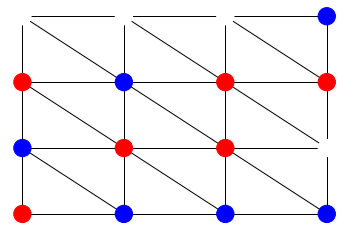

red won


In [14]:
while not is_final:
        frame = visualize_state(env)
        display.clear_output(wait=True)
        display.display(frame)
        time.sleep(1)
        #Add SAP in case there are new states
        action_list = env.legal_actions()
        action = random.sample(action_list,1)[0]
        next_state,reward,is_final = env.step(action)
        state = next_state
display.clear_output(wait=True)
frame = visualize_state(env)
display.display(frame)
print(f"{COLOR_MAP[env.player]} won")

In [16]:
class MCT:
    def __init__(env,ACTOR):
        self.env = env
        self.ANET = ANET
    
    def rollout(self):
        pass

class Node:
    def __init__(state):
        self.state = state
        self.qvalue = 0

[(1, 0), (1, 1), (0, 0)]

In [127]:
sides = {(1,0):(cells[0,:],cells[3,:]), (0,1):(cells[:,0],cells[:,3])}


In [134]:
visited = set()

In [144]:
cell = cells[0][0]
[neig for cell.neighboars.values() if neig.state == self.player]